# [O/Fe] in Milky Way Mapper

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
from astropy.table import Table
from astropy.io import fits
from astropy import coordinates as coords
import astropy.units as u
from apogee_tools import import_apogee, apogee_mdf, gen_kde
import paths
from utils import fits_to_pandas, quad_add, get_color_list, get_bin_centers
import _globals

In [3]:
# For now I'm using the astroNN pipeline, but I need to ask Jennifer which to use
fits_path = paths.data / 'MWM' / 'astraAllStarAstroNN-0.5.0.fits.gz'
with fits.open(fits_path) as hdul:
    print(hdul[0].header)
    hdul.info()
    print(hdul[3].header)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                                                                                                          Metadata                                                                                                                                                PIPELINE= 'AstroNN '           / Pipeline name                                  V_ASTRA = '0.5.0   '           / Astra version                                  CREATED = '23-11-01 00:01:19'  / File creation time (UTC %y-%m-%d %H:%M:%S)                                                                                             HDU Descriptions                                                                                                

To do: use ASPCAP, cut the STAR_BAD flags. I want to use HDU 2 (APOGEE on APO)

In [20]:
# Despite what the header says, the ASPCAP fits file has 2 hdus, one for BOSS and one for APOGEE spectra
fits_path = paths.data / 'MWM' / 'astraAllStarASPCAP-0.5.0.fits.gz'
with fits.open(fits_path) as hdul:
    print(hdul[0].header)
    hdul.info()
    print(hdul[2].header)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                                                                                                          Metadata                                                                                                                                                PIPELINE= 'ASPCAP  '           / Pipeline name                                  V_ASTRA = '0.5.0   '           / Astra version                                  CREATED = '23-11-16 06:21:58'  / File creation time (UTC %y-%m-%d %H:%M:%S)                                                                                             HDU Descriptions                                                                                                

In [21]:
mwm_data = fits_to_pandas(fits_path, hdu=2)
mwm_data

,sdss_id,sdss4_apogee_id,gaia_dr2_source_id,gaia_dr3_source_id,tic_v8_id,healpix,carton_0,lead,version_id,catalogid,...,raw_si_h,raw_e_si_h,raw_s_h,raw_e_s_h,raw_ti_h,raw_e_ti_h,raw_ti_2_h,raw_e_ti_2_h,raw_v_h,raw_e_v_h
0,54968703,2M03455109+5955388,474071961785254400,474071961785254400,317571372,13335,NaN,gaia_dr3_source,31,63050394798264488,...,-0.292086,0.006071,-0.409339,0.005790,-0.339466,0.005964,NaN,NaN,-0.736090,0.002810
1,116010946,2M03455125+3159498,216648634427297920,216648634427297920,26393503,45904,NaN,gaia_dr3_source,31,63050396568859167,...,-0.309680,0.006701,-0.520490,0.006531,-0.350545,0.006674,NaN,NaN,-0.774440,0.002761
2,114979218,2M03521555+1818064,49918828630624768,49918828630624768,440724320,67410,NaN,gaia_dr3_source,31,63050396552439324,...,-0.421463,0.010088,-0.423751,0.010089,-0.542645,0.010148,NaN,NaN,-0.606220,0.003592
3,115031735,2M03521570+2245296,64097924425213440,64097924425760896,440704022,60242,NaN,gaia_dr3_source,31,63050396552988608,...,-0.444328,0.000381,-0.477019,0.000376,-0.481377,0.000375,NaN,NaN,-0.682170,0.000180
4,114941357,2M03521583+1251133,37082820650773632,37082820650773632,242883458,76626,NaN,gaia_dr3_source,31,63050396551977516,...,-0.079598,0.000881,-0.116786,0.000875,-0.097946,0.000878,NaN,NaN,-0.552610,0.000382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059516,94596811,2M03484545-1058335,5115707684814361472,5115707684814361472,38615981,116561,NaN,gaia_dr3_source,31,63050395811882387,...,-0.344780,0.006060,-0.218356,0.006091,-0.312190,0.006053,NaN,NaN,-1.035100,0.002509
1059517,55105597,2M03484564+6905141,493696388912125696,493696388912125696,85623490,6420,NaN,gaia_dr3_source,31,63050394801274341,...,-0.669400,0.049834,-1.289790,0.056611,-0.287490,0.047960,NaN,NaN,0.055848,0.013404
1059518,76059297,2M03484598-0604083,3244474787104498176,3244474787104498176,38613344,108369,NaN,gaia_dr3_source,31,63050395128340475,...,0.277027,0.003557,0.169800,0.003607,0.266261,0.003562,NaN,NaN,0.385190,0.001223
1059519,116051329,2M03484604+3913412,223988493019143552,223988493019143552,201302122,35665,NaN,gaia_dr3_source,31,63050396569537105,...,-0.068621,0.002427,-0.129694,0.002420,-0.106191,0.002423,NaN,NaN,-0.149540,0.001000


In [22]:
mwm_data.columns.to_list()

['sdss_id',
 'sdss4_apogee_id',
 'gaia_dr2_source_id',
 'gaia_dr3_source_id',
 'tic_v8_id',
 'healpix',
 'carton_0',
 'lead',
 'version_id',
 'catalogid',
 'catalogid21',
 'catalogid25',
 'catalogid31',
 'n_associated',
 'n_neighborhood',
 'sdss4_apogee_target1_flags',
 'sdss4_apogee_target2_flags',
 'sdss4_apogee2_target1_flags',
 'sdss4_apogee2_target2_flags',
 'sdss4_apogee2_target3_flags',
 'sdss4_apogee_member_flags',
 'sdss4_apogee_extra_target_flags',
 'ra',
 'dec',
 'l',
 'b',
 'plx',
 'e_plx',
 'pmra',
 'e_pmra',
 'pmde',
 'e_pmde',
 'gaia_v_rad',
 'gaia_e_v_rad',
 'g_mag',
 'bp_mag',
 'rp_mag',
 'j_mag',
 'e_j_mag',
 'h_mag',
 'e_h_mag',
 'k_mag',
 'e_k_mag',
 'ph_qual',
 'bl_flg',
 'cc_flg',
 'w1_mag',
 'e_w1_mag',
 'w1_flux',
 'w1_dflux',
 'w1_frac',
 'w2_mag',
 'e_w2_mag',
 'w2_flux',
 'w2_dflux',
 'w2_frac',
 'w1uflags',
 'w2uflags',
 'w1aflags',
 'w2aflags',
 'mag4_5',
 'd4_5m',
 'rms_f4_5',
 'sqf_4_5',
 'mf4_5',
 'csf',
 'zgr_teff',
 'zgr_e_teff',
 'zgr_logg',
 'zgr_e_l

Sample cuts & calculate [O/Fe] values and errors. I need to get the proper quality flags for astroNN / ASPCAP.

In [23]:
sample = mwm_data[(mwm_data['snr'] > 80) & 
                  (mwm_data['logg'] > 1) & 
                  (mwm_data['logg'] < 3.8) & 
                  (mwm_data['teff'] > 3500) & 
                  (mwm_data['teff'] < 5500)].copy()
sample.dropna(subset=['fe_h', 'o_h'])
sample.reset_index(inplace=True, drop=True)
sample['O_FE'] = sample['o_h'] - sample['fe_h']
sample['O_FE_ERR'] = quad_add(sample['e_o_h'], sample['e_fe_h'])
# add duplicate columns with consistent names from APOGEE
sample['FE_H'] = sample['fe_h'].copy()
sample['FE_H_ERR'] = sample['e_fe_h'].copy()
sample

,sdss_id,sdss4_apogee_id,gaia_dr2_source_id,gaia_dr3_source_id,tic_v8_id,healpix,carton_0,lead,version_id,catalogid,...,raw_ti_h,raw_e_ti_h,raw_ti_2_h,raw_e_ti_2_h,raw_v_h,raw_e_v_h,O_FE,O_FE_ERR,FE_H,FE_H_ERR
0,116010946,2M03455125+3159498,216648634427297920,216648634427297920,26393503,45904,NaN,gaia_dr3_source,31,63050396568859167,...,-0.350545,0.006674,NaN,NaN,-0.77444,0.002761,0.165681,0.042832,-0.440753,0.011268
1,115031735,2M03521570+2245296,64097924425213440,64097924425760896,440704022,60242,NaN,gaia_dr3_source,31,63050396552988608,...,-0.481377,0.000375,NaN,NaN,-0.68217,0.000180,0.061359,0.030318,-0.524303,0.010089
2,114941357,2M03521583+1251133,37082820650773632,37082820650773632,242883458,76626,NaN,gaia_dr3_source,31,63050396551977516,...,-0.097946,0.000878,NaN,NaN,-0.55261,0.000382,-0.015609,0.031277,-0.130393,0.010183
3,115029776,2M03521583+2129049,63675918118074240,63675918118074240,440704542,62290,NaN,gaia_dr3_source,31,63050396552967384,...,-0.306416,0.002394,NaN,NaN,-0.63475,0.001017,0.134281,0.034340,-0.331533,0.010481
4,76315157,2M03521608+0923173,3302476533731766400,3302476533731766400,345453479,81746,NaN,gaia_dr3_source,31,63050395130270017,...,-0.310903,0.002196,NaN,NaN,-0.42060,0.000946,0.093151,0.033987,-0.306583,0.010466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418409,116012082,2M03484436+3206590,216827442507284864,216827442507284864,26529654,45905,NaN,gaia_dr3_source,31,63050396568870197,...,-0.372898,0.002897,NaN,NaN,-0.75906,0.001375,0.085641,0.035345,-0.447573,0.010665
418410,54636799,2M03484443+5409069,444479091656883840,444479091656883840,86637304,18685,NaN,gaia_dr3_source,31,63050394790173013,...,0.196530,0.001035,NaN,NaN,-0.16905,0.000304,0.016659,0.031530,0.019210,0.010150
418411,115028161,2M03484463+2052406,63258236840589056,63258236840589056,440689754,63313,NaN,gaia_dr3_source,31,63050396552949649,...,0.019536,0.001810,NaN,NaN,-0.59001,0.000866,0.013251,0.033119,-0.021603,0.010411
418412,114948039,2M03484484+1416348,39727833309894400,39727833309894400,59003384,73553,NaN,gaia_dr3_source,31,63050396552057306,...,-0.300524,0.001440,NaN,NaN,-0.57891,0.000605,0.040747,0.032429,-0.258403,0.010284


Calculate galactocentric coordinates

In [24]:
ra = np.array(sample['ra']) * u.deg
dec = np.array(sample['dec']) * u.deg
d = np.array(sample['r_med_photogeo']) * u.pc
sky = coords.SkyCoord(ra=ra, dec=dec, distance=d, frame='icrs')
galactocentric = sky.transform_to(frame=coords.Galactocentric())
galactocentric.representation_type = 'cylindrical'
galactocentric
sample['GALR'] = galactocentric.rho.to(u.kpc).value
sample['GALPHI'] = galactocentric.phi.to(u.deg).value
sample['GALZ'] = galactocentric.z.to(u.kpc).value
sample

,sdss_id,sdss4_apogee_id,gaia_dr2_source_id,gaia_dr3_source_id,tic_v8_id,healpix,carton_0,lead,version_id,catalogid,...,raw_e_ti_2_h,raw_v_h,raw_e_v_h,O_FE,O_FE_ERR,FE_H,FE_H_ERR,GALR,GALPHI,GALZ
0,116010946,2M03455125+3159498,216648634427297920,216648634427297920,26393503,45904,NaN,gaia_dr3_source,31,63050396568859167,...,NaN,-0.77444,0.002761,0.165681,0.042832,-0.440753,0.011268,12.087988,173.578696,-1.286873
1,115031735,2M03521570+2245296,64097924425213440,64097924425760896,440704022,60242,NaN,gaia_dr3_source,31,63050396552988608,...,NaN,-0.68217,0.000180,0.061359,0.030318,-0.524303,0.010089,9.947272,177.879409,-0.787836
2,114941357,2M03521583+1251133,37082820650773632,37082820650773632,242883458,76626,NaN,gaia_dr3_source,31,63050396551977516,...,NaN,-0.55261,0.000382,-0.015609,0.031277,-0.130393,0.010183,8.721607,179.757534,-0.333179
3,115029776,2M03521583+2129049,63675918118074240,63675918118074240,440704542,62290,NaN,gaia_dr3_source,31,63050396552967384,...,NaN,-0.63475,0.001017,0.134281,0.034340,-0.331533,0.010481,9.832419,178.162043,-0.768381
4,76315157,2M03521608+0923173,3302476533731766400,3302476533731766400,345453479,81746,NaN,gaia_dr3_source,31,63050395130270017,...,NaN,-0.42060,0.000946,0.093151,0.033987,-0.306583,0.010466,9.291797,179.937830,-0.733905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418409,116012082,2M03484436+3206590,216827442507284864,216827442507284864,26529654,45905,NaN,gaia_dr3_source,31,63050396568870197,...,NaN,-0.75906,0.001375,0.085641,0.035345,-0.447573,0.010665,12.102105,173.705737,-1.250867
418410,54636799,2M03484443+5409069,444479091656883840,444479091656883840,86637304,18685,NaN,gaia_dr3_source,31,63050394790173013,...,NaN,-0.16905,0.000304,0.016659,0.031530,0.019210,0.010150,9.831466,173.759186,0.018624
418411,115028161,2M03484463+2052406,63258236840589056,63258236840589056,440689754,63313,NaN,gaia_dr3_source,31,63050396552949649,...,NaN,-0.59001,0.000866,0.013251,0.033119,-0.021603,0.010411,9.273240,178.663139,-0.536094
418412,114948039,2M03484484+1416348,39727833309894400,39727833309894400,59003384,73553,NaN,gaia_dr3_source,31,63050396552057306,...,NaN,-0.57891,0.000605,0.040747,0.032429,-0.258403,0.010284,9.009043,179.466832,-0.496640


In [25]:
sample.to_csv(paths.data / 'MWM' / 'sample.csv', index=False)

2D histogram of location of stars in the sample

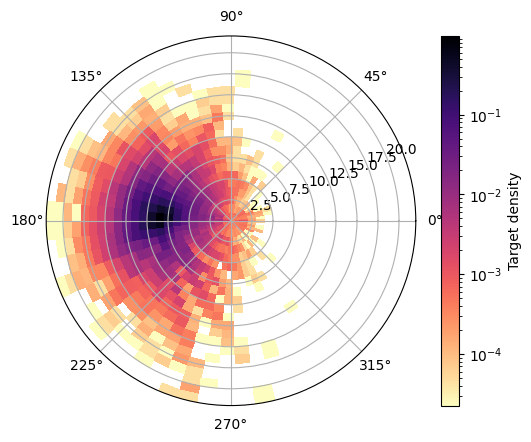

In [26]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
abins = np.linspace(-np.pi, np.pi, 60)
rbins = np.arange(0, 23, 1)
hist, _, _ = np.histogram2d(sample['GALPHI']*np.pi/180, sample['GALR'], bins=(abins, rbins), density=True)
A, R = np.meshgrid(abins, rbins)
pc = ax.pcolormesh(A, R, hist.T, cmap='magma_r', norm=LogNorm())
fig.colorbar(pc, label='Target density')
plt.show()

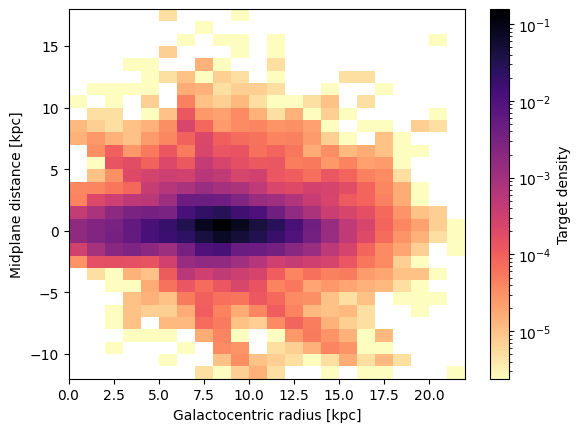

In [27]:
fig, ax = plt.subplots()
rbins = np.arange(0, 23, 1)
zbins = np.arange(-12, 19, 1)
hist, _, _ = np.histogram2d(sample['GALR'], sample['GALZ'], bins=(rbins, zbins), density=True)
R, Z = np.meshgrid(rbins, zbins)
pc = ax.pcolormesh(R, Z, hist.T, cmap='magma_r', norm=LogNorm())
ax.set_xlabel('Galactocentric radius [kpc]')
ax.set_ylabel('Midplane distance [kpc]')
fig.colorbar(pc, label='Target density')
plt.show()

Median [O/Fe] in bins of Rgal and z

In [28]:
rbins = np.arange(0, 31, 1)
zbins = np.arange(-21, 21, 1)
binned = sample.groupby([pd.cut(sample.GALR, rbins), pd.cut(sample.GALZ, zbins)], observed=False)
binned['O_FE'].median()

GALR      GALZ      
(0, 1]    (-21, -20]   NaN
          (-20, -19]   NaN
          (-19, -18]   NaN
          (-18, -17]   NaN
          (-17, -16]   NaN
                        ..
(29, 30]  (15, 16]     NaN
          (16, 17]     NaN
          (17, 18]     NaN
          (18, 19]     NaN
          (19, 20]     NaN
Name: O_FE, Length: 1230, dtype: float32

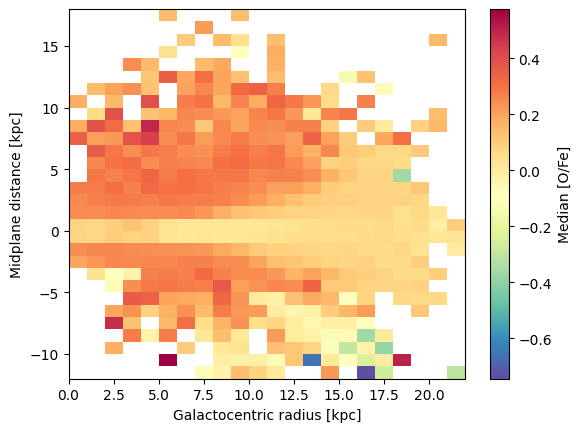

In [29]:
fig, ax = plt.subplots()
R, Z = np.meshgrid(rbins, zbins)
pc = ax.pcolormesh(R, Z, np.reshape(binned['O_FE'].median(), (rbins.shape[0]-1, zbins.shape[0]-1)).T, cmap='Spectral_r')
ax.set_xlabel('Galactocentric radius [kpc]')
ax.set_ylabel('Midplane distance [kpc]')
ax.set_xlim((0, 22))
ax.set_ylim((-12, 18))
fig.colorbar(pc, label='Median [O/Fe]')
fig.show()

[O/Fe] distributions from MWM vs APOGEE

In [30]:
apogee_data = import_apogee()

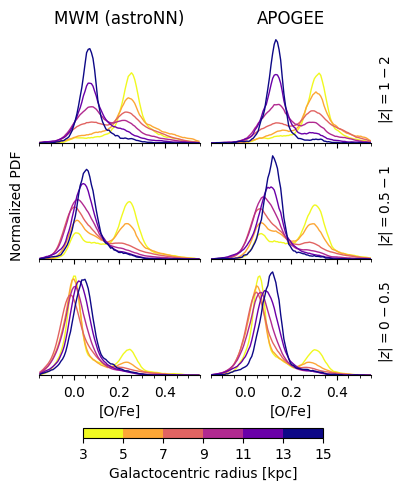

In [31]:
import distribution_functions as dfs
plt.style.use('default')
fig, axs = dfs.setup_axes(ncols=2, xlabel='[O/Fe]', figure_width=4)
colors = get_color_list(plt.get_cmap('plasma_r'), _globals.GALR_BINS)
mdf_kwargs = {'bins': 100, 'range': (-0.15, 0.55), 'smoothing': 0.05}
# Plot MWM distributions
dfs.plot_apogee_mdfs(sample, axs[:,0], col='O_FE', colors=colors, label='MWM (astroNN)',
                     **mdf_kwargs)
# Plot APOGEE distributions
dfs.plot_apogee_mdfs(apogee_data, axs[:,1], col='O_FE', colors=colors, 
                     **mdf_kwargs)
axs[0,0].set_xlim(mdf_kwargs['range'])
axs[0,0].xaxis.set_major_locator(MultipleLocator(0.2))
axs[0,0].xaxis.set_minor_locator(MultipleLocator(0.05))
for ax in axs[:,0]:
    ax.set_ylim((0, None))
plt.show()